In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from scipy import stats
import scipy as sp
import datetime as dt

from ei_net import * 
from ce_net import * 

from collections import Counter

%matplotlib inline

In [2]:
##########################################
############ PLOTTING SETUP ##############
EI_cmap = "Greys"
where_to_save_pngs = "../figs/pngs/"
where_to_save_pdfs = "../figs/pdfs/"
save = True
plt.rc('axes', axisbelow=True)
##########################################
##########################################

# The emergence of informative higher scales in complex networks

# Chapter 08 - Miscellaneous Causal Emergence
_______________

## 8.1 All possible coarse-grainings

In [3]:
G = check_network(nx.barabasi_albert_graph(8,1))
micro_ei = effective_information(G)

In [4]:
all_macro_mappings = all_possible_mappings(G) # i think this works
macro_types = {i: 'spatem1' for i in G.nodes()}

current_best_ei = micro_ei
current_best_partition = dict(zip(list(G.nodes()), list(G.nodes())))

In [5]:
curr = dt.datetime.now()
ei_list = []
for ix, possible_mapping in enumerate(all_macro_mappings):
    if ix % 1000==0:
        print("%.3f of the way done."%(ix / len(all_macro_mappings)))
    MACRO = create_macro(G, possible_mapping, macro_types)
    macro_ei = effective_information(MACRO)
    
    if macro_ei > current_best_ei:
        current_best_ei = macro_ei
        current_best_partition = possible_mapping
        
    ei_list.append(macro_ei)
    
diff = dt.datetime.now()-curr

0.000 of the way done.
0.242 of the way done.
0.483 of the way done.
0.725 of the way done.
0.966 of the way done.


In [6]:
Gm = check_network(create_macro(G, current_best_partition, macro_types))

In [7]:
ns = 750 
lw = 4
nc = 'w'
nec = '#333333'
mc = '#00cc84'
ec = '#666666'
ew = 4.0
fs = 14
ws = 20

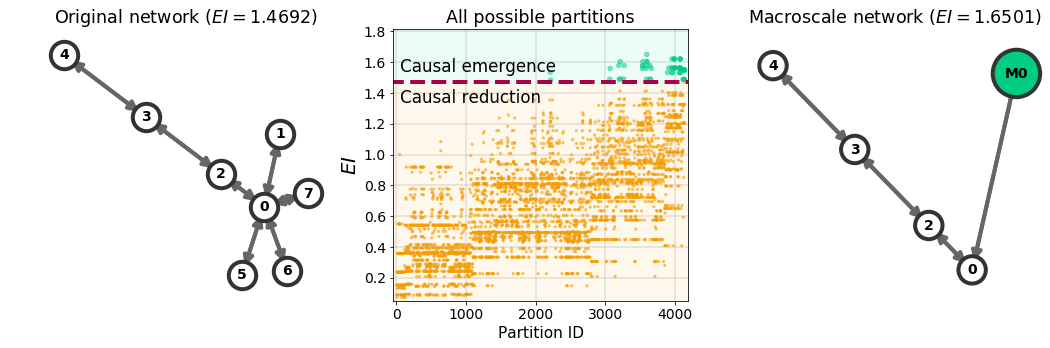

In [8]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3,figsize=(18,5))

# first subplot
pos0 = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(G, pos0, node_color=nc, node_size=ns, edgecolors=nec, linewidths=lw, ax=ax0)
nx.draw_networkx_edges(G, pos0, edge_color=ec, width=ew, arrowsize=ws, ax=ax0)
nx.draw_networkx_labels(G,pos0, font_size=fs, font_weight='bold', ax=ax0)
ax0.set_axis_off()
ax0.set_title(r'Original network ($EI=%.4f$)'%micro_ei,fontsize=fs*1.25)

# second subplot
cols = ['#f59c01' if i <= micro_ei else '#00cc84' for i in ei_list]
sizs = [20 if i<=micro_ei else 75 for i in ei_list]
ax1.scatter(list(range(len(all_macro_mappings))), ei_list, marker='.', c=cols, s=sizs, alpha=0.5)
ax1.fill_between(range(-100,5000), micro_ei, 0, color='#f59c01', alpha=0.08)
ax1.fill_between(range(-100,5000), micro_ei, max(ei_list)*1.1, color='#00cc84', alpha=0.08)
ax1.hlines(micro_ei,-100,5000,color='#aa0047',linestyle='--',linewidth=4.0)
ax1.set_xlim(-50,len(all_macro_mappings)+50)
ax1.set_ylim(0.05,max(ei_list)*1.1)
ax1.tick_params(axis='both', which='major', labelsize=fs)
ax1.set_xlabel('Partition ID', fontsize=fs*1.1)
ax1.set_ylabel('$EI$', fontsize=fs*1.4)
ax1.grid(linewidth=2.0, alpha=0.2, color='#999999')
ax1.text(50, micro_ei+micro_ei/15, 'Causal emergence', fontsize=fs*1.2, verticalalignment='center')
ax1.text(50, micro_ei-micro_ei/15, 'Causal reduction', fontsize=fs*1.2, verticalalignment='center')
ax1.set_title('All possible partitions', fontsize=fs*1.25)

# third subplot
micro_cols = [nc if k==v else mc for k, v in current_best_partition.items()]
inds = np.where(np.array(list(current_best_partition.values())) > G.number_of_nodes()-1)[0]
n_macronodes = len(np.unique(np.array(list(current_best_partition.values()))[inds]))
macro_cols = [nc]*(Gm.number_of_nodes()-n_macronodes) + [mc]*n_macronodes
macro_size = [ns]*(Gm.number_of_nodes()-n_macronodes) + [ns*3]*n_macronodes
micronodes = [k for k, v in current_best_partition.items() if k==v]
macro_labels = micronodes + ['M%i'%i for i in range(n_macronodes+1)]
micronodes = [k for k, v in current_best_partition.items() if k==v]
fixed1 = dict(zip(Gm.nodes(),[pos0[i] for i in micronodes]))
pos1 = nx.spring_layout(Gm.nodes(), pos=fixed1, fixed=list(fixed1.keys()), iterations=1)
nx.draw_networkx_nodes(Gm, pos1, node_color=macro_cols, 
                       node_size=macro_size, edgecolors=nec, linewidths=lw, ax=ax2)
nx.draw_networkx_edges(Gm, pos1, edge_color=ec, width=ew, arrowsize=ws, ax=ax2)
nx.draw_networkx_labels(Gm,pos1, labels=dict(zip(Gm.nodes(),macro_labels)),
                        font_size=fs, font_weight='bold', ax=ax2)
ax2.set_axis_off()
ax2.set_title(r'Macroscale network ($EI=%.4f$)'%current_best_ei, fontsize=fs*1.25)

if save:
    plt.savefig("../figs/pngs/AllPossibleMacros.png", bbox_inches='tight', dpi=425)
    plt.savefig("../figs/pdfs/AllPossibleMacros.pdf", bbox_inches='tight')
    
plt.show()

__________________

## 8.2 Inside the causal emergence algorithm, with the Karate club

In [9]:
G = nx.karate_club_graph()
CE = causal_emergence(G)

Starting with this TPM:
 [[0.     0.0625 0.0625 ... 0.0625 0.     0.    ]
 [0.1111 0.     0.1111 ... 0.     0.     0.    ]
 [0.1    0.1    0.     ... 0.     0.1    0.    ]
 ...
 [0.1667 0.     0.     ... 0.     0.1667 0.1667]
 [0.     0.     0.0833 ... 0.0833 0.     0.0833]
 [0.     0.     0.     ... 0.0588 0.0588 0.    ]]

Search started ... EI_micro = 2.3501

Checking node 00032 (0.0% done)... coarse-grained network size = 00034
Checking node 00005 (2.9% done)... coarse-grained network size = 00034
Checking node 00028 (5.9% done)... coarse-grained network size = 00034
Checking node 00004 (8.8% done)... coarse-grained network size = 00034
Checking node 00014 (11.8% done)... coarse-grained network size = 00034
	Just found a successful macro grouping ... the EI_current = 2.3626
	Just found a successful macro grouping ... the EI_current = 2.3717
	Just found a successful macro grouping ... the EI_current = 2.3760
Checking node 00012 (14.7% done)... coarse-grained network size = 00031
Chec

In [10]:
print("\nInside the CE dictionary are these objects\n", list(CE.keys()),'\n')
print("EI of the microscale network\n",CE['EI_micro'],'\n')
print("EI of the macroscale network\n", CE['EI_macro'],'\n')
print("The mapping itself\n", CE['mapping'],'\n')


Inside the CE dictionary are these objects
 ['G_macro', 'G_micro', 'mapping', 'macro_types', 'inaccuracy', 'EI_micro', 'EI_macro'] 

EI of the microscale network
 2.3500950888734686 

EI of the macroscale network
 2.407995348288915 

The mapping itself
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 35, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 35, 14: 34, 15: 34, 16: 16, 17: 35, 18: 18, 19: 35, 20: 34, 21: 21, 22: 34, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33} 



In [11]:
ns = 350 
lw = 2.5
nc = '#333333'
mc = 'dodgerblue'
ec = '#999999'
ew = 4.0
fs = 12
fc = 'w'
ws = 20

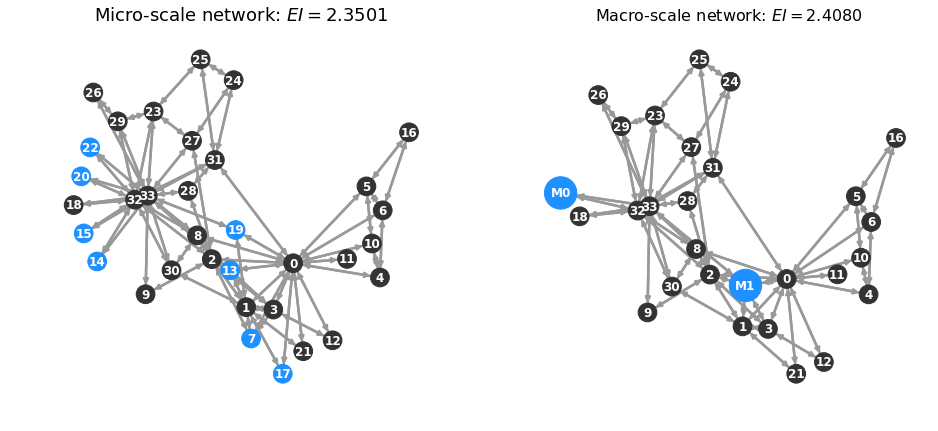

In [12]:
micro_cols = [nc if k==v else mc for k, v in CE['mapping'].items()]
inds = np.where(np.array(list(CE['mapping'].values())) > G.number_of_nodes()-1)[0]
n_macronodes = len(np.unique(np.array(list(CE['mapping'].values()))[inds]))
macro_cols = [nc]*(CE['G_macro'].number_of_nodes()-n_macronodes) + [mc]*n_macronodes
macro_size = [ns]*(CE['G_macro'].number_of_nodes()-n_macronodes) + [ns*3]*n_macronodes

pos0 = nx.spring_layout(G)
micronodes = [k for k, v in CE['mapping'].items() if k==v]
fixed1 = dict(zip(CE['G_macro'].nodes(),[pos0[i] for i in micronodes]))
pos1 = nx.spring_layout(CE['G_macro'], pos=fixed1, fixed=list(fixed1.keys()))
macro_labels = micronodes + ['M%i'%i for i in range(n_macronodes+1)]


fig, (ax0,ax1) = plt.subplots(1,2,figsize=(16,7))

# first subplot
nx.draw(CE['G_micro'], pos0, edge_color=ec, 
        node_color=micro_cols, node_size=ns, width=lw, ax=ax0)
nx.draw_networkx_labels(CE['G_micro'], pos0, 
                        font_color=fc, font_size=fs, font_weight='bold', ax=ax0)
ax0.set_title(r'Micro-scale network: $EI=%.4f$'%CE['EI_micro'], 
              fontsize=fs*1.5)

# second subplot
nx.draw(CE['G_macro'], pos1, edge_color=ec,
        node_color=macro_cols, node_size=macro_size, width=lw,  ax=ax1)
nx.draw_networkx_labels(CE['G_macro'], pos1,
                        labels=dict(zip(CE['G_macro'].nodes(), macro_labels)), 
                        font_color=fc, font_size=fs, font_weight='bold', ax=ax1)
ax1.set_title(r'Macro-scale network: $EI=%.4f$'%CE['EI_macro'], size=16)

if save:
    plt.savefig("../figs/pngs/Micro_Macro_karate.png", bbox_inches='tight', dpi=425)
    plt.savefig("../figs/pdfs/Micro_Macro_karate.pdf", bbox_inches='tight')
    
plt.show()

______________

In [13]:
def preferential_attachment_network(N, alpha=1.0, m=1):
    """
    Generates a network based off of a preferential attachment 
    growth rule. Under this growth rule, new nodes place their 
    $m$ edges to nodes already present in the graph, G, with 
    a probability proportional to $k^\alpha$.
    
    Params
    ------
    N (int): the desired number of nodes in the final network
    alpha (float): the exponent of preferential attachment. 
                   When alpha is less than 1.0, we describe it
                   as sublinear preferential attachment. At
                   alpha > 1.0, it is superlinear preferential
                   attachment. And at alpha=1.0, the network 
                   was grown under linear preferential attachment,
                   as in the case of Barabasi-Albert networks.
    m (int): the number of new links that each new node joins
             the network with.
             
    Returns
    -------
    G (nx.Graph): a graph grown under preferential attachment.
    
    """
    G = nx.Graph()
    G = nx.complete_graph(m+1)

    for node_i in range(m+1,N):
        degrees = np.array(list(dict(G.degree()).values()))
        probs = (degrees**alpha) / sum(degrees**alpha)
        eijs = np.random.choice(
                    G.number_of_nodes(), size=(m,), 
                    replace=False, p=probs)
        for node_j in eijs:
            G.add_edge(node_i, node_j)

    return G

In [14]:
colorz = ["#6f8fcd","#5ac4a4","#c75a81","#c267b5","#cb5f56",
          "#ca6631","#c5b33c","#8965d0","#6ec559","#b09563"]
np.random.shuffle(colorz)

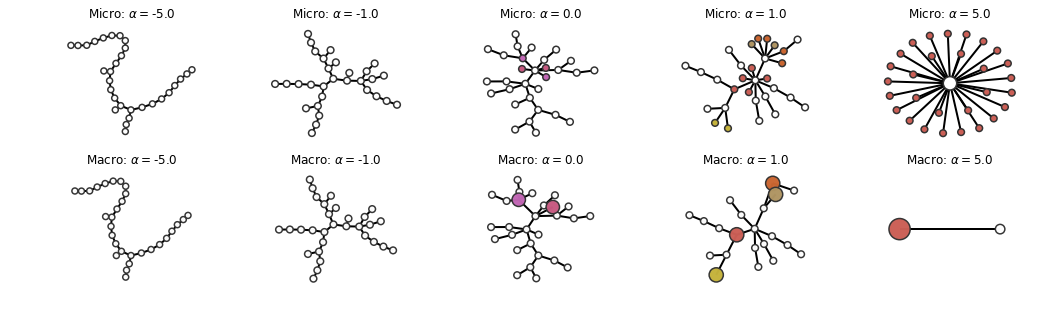

In [15]:
N = 30
t = 1000
m = 1

mult = 1.5
fig,((ax0,ax1,ax2,ax3,ax8),(ax4,ax5,ax6,ax7,ax9))=plt.subplots(2,5,figsize=(12*mult,3.25*mult))
plt.subplots_adjust(wspace=0.1, hspace=0.22)
top_ax = [ax0,ax1,ax2,ax3,ax8]
bot_ax = [ax4,ax5,ax6,ax7,ax9]

i = 0
for alpha in [-5.0,-1.0,0.0,1.0,5.0]:
    np.random.shuffle(colorz)

    G = preferential_attachment_network(N, alpha, m)
    CE = causal_emergence(G, t=t, printt=False)
    mapp = CE['mapping']
    Gm = CE['G_macro']
    
    micro_cols = []
    macs = {}
    mac_col_map = np.unique([i for i in list(mapp.values()) if i >= G.number_of_nodes()])
    mac_col_dict = {mac_col_map[i]:colorz[i] for i in range(len(mac_col_map))}
    for k,v in mapp.items():
        if k==v:
            micro_cols.append('w')
        else:
            micro_cols.append(mac_col_dict[v])
    inds = np.where(np.array(list(mapp.values())) > G.number_of_nodes()-1)[0]
    extra_cols = list(np.unique(np.array(micro_cols)[inds]))
    n_macronodes = len(np.unique(np.array(list(mapp.values()))[inds]))
    macro_cols = ['w']*(Gm.number_of_nodes()-n_macronodes) + list(mac_col_dict.values())

    ns = 45
    micro_size = [ns]*G.number_of_nodes()
    macro_size = [ns]*(Gm.number_of_nodes()-n_macronodes) + [ns*(3+i/2)]*n_macronodes

    if i==4:
        imax = [k for k,v in dict(G.degree()).items() if v > 3][0]
        micro_size[imax] = micro_size[imax]*4

    pos1 = nx.kamada_kawai_layout(G)
    if i==0:
        micro_size = np.array(micro_size)*0.8
        pos1 = nx.spring_layout(G)

    nx.draw_networkx_nodes(G, pos1, node_size=micro_size, node_color=micro_cols, 
                           linewidths=1.5, edgecolors='#333333', ax=top_ax[i])
    nx.draw_networkx_edges(G, pos1, ax=top_ax[i], width=2.0)
    top_ax[i].set_title(r'Micro: $\alpha=$%.1f'%alpha)
    xlims = [x[0] for x in list(pos1.values())]
    if i==0:
        xlims[0] = xlims[0]*0.8
        xlims[1] = xlims[1]*0.8

    ylims = [y[1] for y in list(pos1.values())]
    top_ax[i].set_xlim(min(xlims)-.5,max(xlims)+.5)
    top_ax[i].set_ylim(min(ylims)-.2,max(ylims)+.2)
    top_ax[i].set_axis_off()

    Gm = Gm.to_undirected()
    micronodes = [k for k, v in mapp.items() if k==v]
    fixed1 = dict(zip(Gm.nodes(),[pos1[i] for i in micronodes]))
    pos2 = nx.spring_layout(Gm, pos=fixed1, fixed=list(fixed1.keys()))

    if i==4:
        pos2 = nx.circular_layout(Gm)
    if Gm.number_of_nodes() - G.number_of_nodes()==0:
        pos2 = pos1.copy()
    xlims = [x[0] for x in list(pos2.values())]
    bot_ax[i].set_xlim(min(xlims)-.6,max(xlims)+.6)

    if i==4:
        xlims = [x[0] for x in list(pos2.values())]
        bot_ax[i].set_xlim(min(xlims)-.85,max(xlims)+.85)
        macro_size = np.array(macro_size)*2

    if i==0:
        macro_size = np.array(macro_size)*0.8

    ylims = [y[1] for y in list(pos2.values())]
    bot_ax[i].set_ylim(min(ylims)-.2,max(ylims)+.2)

    nx.draw_networkx_nodes(Gm, pos2, node_size=macro_size, node_color=macro_cols, alpha=0.98,
                           linewidths=1.5, edgecolors='#333333', ax=bot_ax[i])
    nx.draw_networkx_edges(Gm, pos2, ax=bot_ax[i], width=2.0)
    bot_ax[i].set_title(r'Macro: $\alpha=$%.1f'%alpha)
    bot_ax[i].set_axis_off()

    bot_ax[i].set_axis_off()
    i+=1

if save:
    plt.savefig('../figs/pngs/pref_attach_networks.png', dpi=425, bbox_inches='tight')
    plt.savefig('../figs/pdfs/pref_attach_networks.pdf', dpi=425, bbox_inches='tight')

plt.show()

## 8.3 Inaccuracies

In [27]:
N = 80
G = preferential_attachment_network(N,alpha=1.1)
t = 100

In [28]:
startT = dt.datetime.now()
CE = causal_emergence(G, t=t, check_inacc=True, printt=False)
finisH = dt.datetime.now()
diff = finisH-startT

print('Finished causal emergence, took', diff, "seconds.")

Finished causal emergence, took 0:01:45.023254 seconds.


In [29]:
mapp = CE['mapping']
Gm = CE['G_macro']
inaccs = CE['inaccuracy']

In [30]:
# node colors
micro_cols = []
macs = {}
mac_col_map = np.unique([i for i in list(mapp.values()) if i >= G.number_of_nodes()])
mac_col_dict = {mac_col_map[i]:colorz[i] for i in range(len(mac_col_map))}
for k,v in mapp.items():
    if k==v:
        micro_cols.append('w')
    else:
        micro_cols.append(mac_col_dict[v])

inds = np.where(np.array(list(mapp.values())) > G.number_of_nodes()-1)[0]
extra_cols = list(np.unique(np.array(micro_cols)[inds]))
n_macronodes = len(np.unique(np.array(list(mapp.values()))[inds]))
macro_cols = ['w']*(Gm.number_of_nodes()-n_macronodes) + list(mac_col_dict.values())

# node sizes
ns = 100
micro_size = [ns]*G.number_of_nodes()
macro_size = [ns]*(Gm.number_of_nodes()-n_macronodes) + [ns*2.75]*n_macronodes

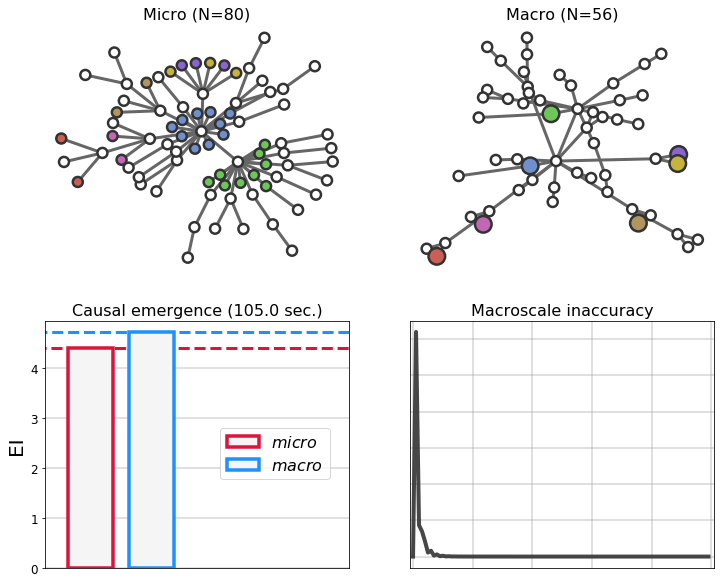

In [31]:
fig, ((ax00,ax02),(ax1,ax2)) = plt.subplots(2, 2, figsize=(12,10))

# first subplot
pos1 = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(G, pos1, node_size=micro_size, node_color=micro_cols, 
                       linewidths=2.5, edgecolors='#333333', ax=ax00)
nx.draw_networkx_edges(G, pos1, edge_color='#666666', ax=ax00, width=3.0)
ax00.set_title('Micro (N=%i)'%N,fontsize=16)
ax00.set_axis_off()

# second subplot
Gm = Gm.to_undirected()
pos2 = nx.spring_layout(Gm, pos=pos1)
nx.draw_networkx_nodes(Gm, pos2, node_size=macro_size, node_color=macro_cols, 
                       linewidths=2.5, edgecolors='#333333', ax=ax02)
nx.draw_networkx_edges(Gm, pos2, edge_color='#666666', ax=ax02, width=3.0)
ax02.set_title('Macro (N=%i)'%Gm.number_of_nodes(),fontsize=16)
ax02.set_axis_off()

# third subplot
ax1.bar(1.15,CE['EI_micro'], facecolor='#F5F5F5',edgecolor='crimson',linewidth=3.5,
        width=0.15, label=r'$micro$')
ax1.bar(1.35,CE['EI_macro'], facecolor='#F5F5F5',edgecolor='dodgerblue',linewidth=3.5,
        width=0.15, label=r'$macro$')
ax1.hlines(CE['EI_micro'],2.1,0, color='crimson',zorder=0,linestyle='--',linewidth=3.0)
ax1.hlines(CE['EI_macro'],2,0, color='dodgerblue',zorder=0,linestyle='--',linewidth=3.0)
ax1.set_xlim(1,2)
ax1.tick_params(axis='both', which='major', labelsize=fs)
ax1.set_title("Causal emergence (%.1f sec.)"%diff.total_seconds(),fontsize=16)
ax1.set_ylabel('EI',fontsize=20)
ax1.grid(True, linestyle='-', linewidth=2.0, color='#999999', alpha=0.3)
ax1.set_xticks([])
ax1.legend(bbox_to_anchor=[0.55,0.6], fontsize=16)


# fourth subplot
ax2.plot(inaccs, linewidth=4.0, alpha=0.9, color='#333333')
ax2.set_title("Macroscale inaccuracy",fontsize=16)
ax2.grid(True, linestyle='-', linewidth=2.0, color='#999999', alpha=0.3)
ax2.set_xlim(-1,t+1)

if save:
    plt.savefig('../figs/pngs/causal_emergence_example1.png', dpi=425, bbox_inches='tight')
    plt.savefig('../figs/pdfs/causal_emergence_example1.pdf', bbox_inches='tight')
    
plt.show()

________________________

## 8.4 Inaccuracy, continued

In [21]:
from utilities import add_subplot_axes

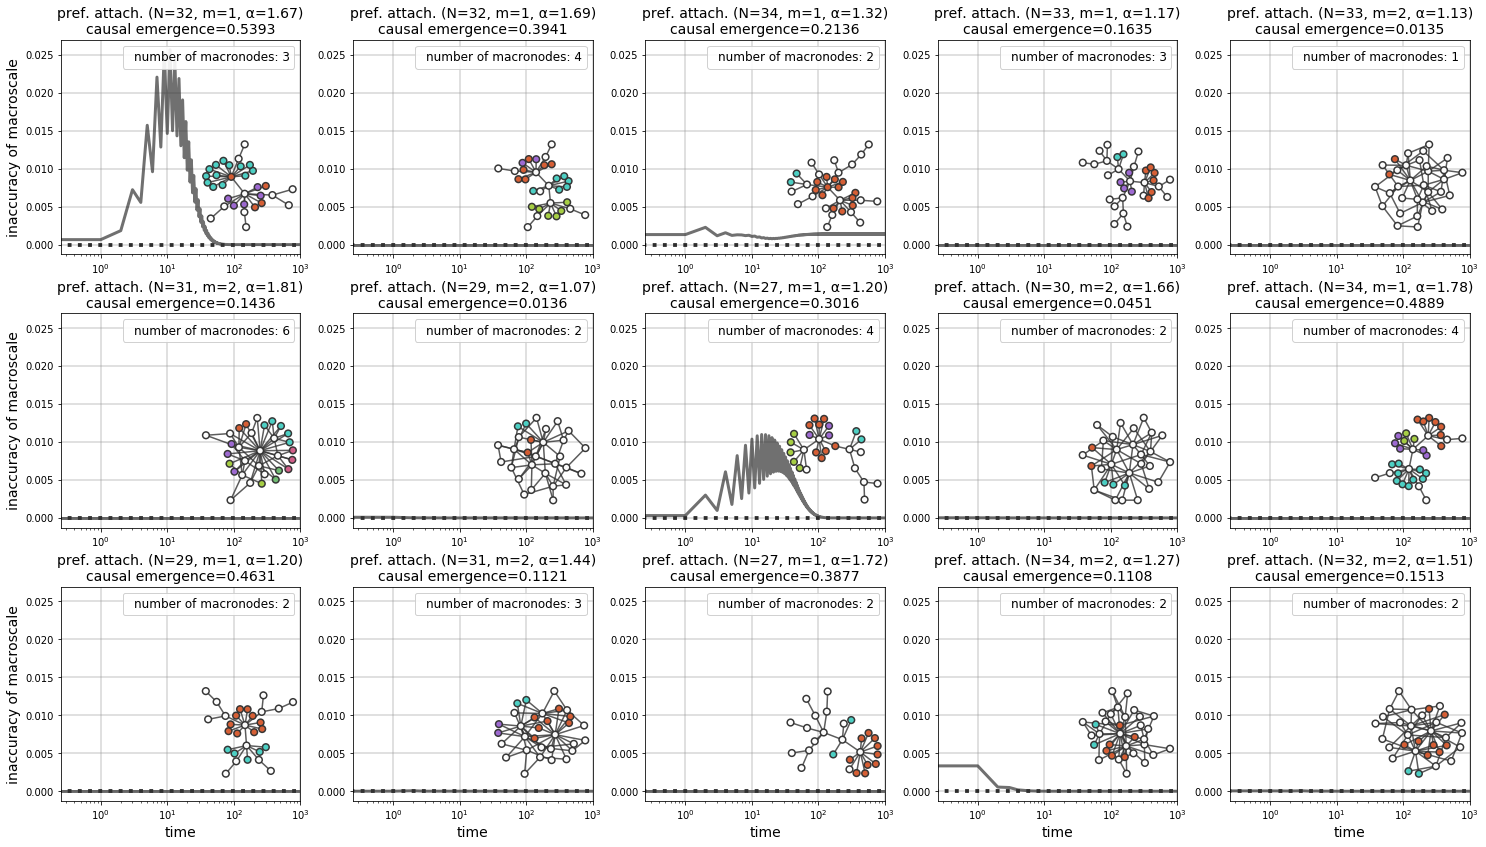

In [23]:
tups=[(0,0), (0,1), (0,2), (0,3), (0,4), 
      (1,0), (1,1), (1,2), (1,3), (1,4), 
      (2,0), (2,1), (2,2), (2,3), (2,4)]

colorz = ["#d75d32",
"#4ad0c4",
"#9d68d2",
"#a6cf41",
"#d15c88",
"#6fbc71",
"#b8974c",
"dodgerblue", 'crimson']

m = 1
t = 1000

maxy = 0
out_ces = []
graphs = []
out_stats = []

for i in range(len(tups)):
    N = np.random.choice(list(range(25,35)))
    m = np.random.choice([1,1,1,2,2])
    alpha = np.round(np.random.uniform(1,2),3)
    G = preferential_attachment_network(N, alpha, m)
    CE = causal_emergence(G, printt=False, t=t)

    types_CE = CE['macro_types']
    spatem1s = len([j for j in types_CE.values() if j=='spatem1'])
    out_stats.append((N,m,alpha,CE['EI_macro']-CE['EI_micro'],spatem1s))

    minacc = CE['inaccuracy']

    txs = np.array(list(range(len(minacc))))
    xvals = np.array(txs)
    means = minacc
    maxy = max([maxy, max(means)])
    Gp = G.to_undirected()

    micro_cols = []
    macs = {}
    for k,v in CE['mapping'].items():
        if k==v:
            micro_cols.append('w')
        else:
            if v not in list(macs.keys()):
                macs[v] = len(macs.keys())
            micro_cols.append(colorz[macs[v]])

    out_ces.append([means,micro_cols])
    graphs.append(Gp)    


tups=[(0,0), (0,1), (0,2), (0,3), (0,4), 
      (1,0), (1,1), (1,2), (1,3), (1,4), 
      (2,0), (2,1), (2,2), (2,3), (2,4)]

fi, ax = plt.subplots(3, 5, figsize=(25.25,14))
plt.subplots_adjust(wspace=0.22, hspace=0.275)

for i, means in enumerate(out_ces):
    micro_cols = means[1]
    means = means[0]
    q = tups[i]
    N = out_stats[i][0]
    m = out_stats[i][1]
    a = out_stats[i][2]
    c = out_stats[i][3]
    s = out_stats[i][4]
    ax[q].set_title("pref. attach. (N=%i, m=%i, α=%.2f)\ncausal emergence=%.4f"%\
                    (N,m,a,c), fontsize=14)

    ax[q].hlines(0, 0, t, alpha=0.8, color='k', linewidth=3.85, linestyle=':')
    ax[q].hlines(0, 0, t, alpha=0.0, color='k', linewidth=3.0, linestyle='-', 
                 label='number of macronodes: %i'%(s))
    ax[q].semilogx(xvals, means, linewidth=3.0, alpha=0.7, color='#333333')

    ax[q].legend(loc=0, framealpha=0.9, fontsize=12, handletextpad=-1.5)
    ax[q].set_xlim(0.25,t)
    ax[q].set_ylim(0-0.05*maxy,1.05*maxy)
    ax[q].grid(linestyle='-', color='#999999', alpha=0.3, linewidth=2.0)

    if q[1]==0:
        ax[q].set_ylabel('inaccuracy of macroscale', fontsize=14)

    if q[0]==2:
        ax[q].set_xlabel('time', fontsize=14)

    Gp = graphs[i]
    h  = 0.1
    rect = [0.58,h,0.415,0.44]
    ax2  = add_subplot_axes(ax[q],rect)

    pos = nx.kamada_kawai_layout(Gp)
    nx.draw_networkx_nodes(Gp, pos, node_size=45, node_color=micro_cols, linewidths=1.5,
                           alpha=0.98, edgecolors='#333333', ax=ax2)
    nx.draw_networkx_edges(Gp, pos, edge_color='#333333', alpha=0.8, ax=ax2, width=1.5)
    ax2.set_axis_off()

if save:
    plt.savefig('../figs/pngs/15_inacc_comparison.png', dpi=425, bbox_inches='tight')
    plt.savefig('../figs/pdfs/15_inacc_comparison.pdf', bbox_inches='tight')
    
plt.show()

__________________